# Predicción de ventas

Los datos entregados corresponden a ventas realizadas en una única tienda Jumbo en el período que comprende desde el 2021-01-02 hasta el 2022-01-09. El objetivo final de la evaluación es realizar una predicción diaria de las ventas de la semana del 17 al 23 de Enero del 2022, es decir, un valor para cada día de la semana y para cada producto (Notar el desfase de una semana entre los datos y el período deseado). Los resultados numéricos concretos de dicha predicción no son relevantes para la evaluación, si no más bien el desarrollo y su dominio que quedará reflejado en el trabajo.

El dataset está compuesto por:


column_name | name      | description
------------|-----------|-------------------------------------------------------
ds          | fecha     | En formato YYYY-MM-DD, corresponde a la fecha de la transacción.
item_id     | producto_id | Identificador del producto que se vendió.
y           | venta     | Cantidad vendida del producto. En caso de ser decimal, se vende a granel (por ejemplo, frutas).
hierarchy_2_code | rubro_id | Código correspondiente al rubro al que pertenece el producto.


En el análisis exploratiorio y de limpieza de los datos separemos el dataset en train y test y luego realizamos la limpieza en el dataset de train. Este es el que vamos a utilizar para realizar las predicciones pero antes introduciremos algunos conceptos a tener en cuenta a la hora de trabajar con series de tiempo.

In [ ]:
# !pip install matplotlib
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

import joblib

sns.set(font_scale=.8)

## Importamos el Dataset

In [3]:
# Importamos el dataset de train con la limpieza realizada en el análisis exploratiorio
ventas = pd.read_csv('datos_ventas_train_sample.csv',
                           sep=',')
ventas.head()

,ds,hierarchy_2_code,item_id,y
0,2021-01-02,60,937937,15.0
1,2021-01-02,82,955764,6.0
2,2021-01-02,101,3935,0.0
3,2021-01-02,15,1403,241.0
4,2021-01-02,82,1138428,0.0


In [4]:
# Importamos el dataset de test
validation = pd.read_csv('datos_ventas_validation_sample.csv',
                           sep=',')
validation.head()

,ds,hierarchy_2_code,item_id,y
0,2022-01-03,101,3906,4.0
1,2022-01-03,60,937937,25.0
2,2022-01-03,82,955764,5.0
3,2022-01-03,15,376635,10.0
4,2022-01-03,71,440500,19.0


In [5]:
df_train = ventas.copy()
df_val = validation.copy()

In [6]:
print(df_train.info(),
      df_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                5490 non-null   object 
 1   hierarchy_2_code  5490 non-null   int64  
 2   item_id           5490 non-null   int64  
 3   y                 5490 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 171.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                105 non-null    object 
 1   hierarchy_2_code  105 non-null    int64  
 2   item_id           105 non-null    int64  
 3   y                 105 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.4+ KB
None None


In [7]:
# Convertimos ds a datetime y los items y rubros a object
df_train['ds'] = pd.to_datetime(df_train['ds'])
df_train[['item_id', 'hierarchy_2_code']] = df_train[['item_id', 'hierarchy_2_code']].astype('object')
df_train.fillna(0, inplace=True)

df_val['ds'] = pd.to_datetime(df_val['ds'])
df_val[['item_id', 'hierarchy_2_code']] = df_val[['item_id', 'hierarchy_2_code']].astype('object')
df_val.fillna(0, inplace=True)

In [8]:
# Chequeamos cuántos items tenemos en el dataset de train
df_train.nunique()

ds                  366
hierarchy_2_code      9
item_id              15
y                   384
dtype: int64

In [9]:
df_val.nunique()

ds                   7
hierarchy_2_code     9
item_id             15
y                   44
dtype: int64

## Ajuste de Modelo ARIMA

ARIMA (Autoregressive Integrated Moving Average) es un modelo estadístico ampliamente utilizado para analizar y predecir series temporales. La fórmula general del modelo ARIMA se expresa de la siguiente manera:
$$
ARIMA(p, d, q)
$$
Donde:
- "p" es el orden del componente autorregresivo (AR) que representa la dependencia lineal de la serie con sus valores pasados.
- "d" es el número de diferencias necesarias para hacer que la serie sea estacionaria. La diferenciación se realiza para eliminar la tendencia y la estacionalidad.
- "q" es el orden del componente de media móvil (MA) que captura la relación lineal entre la serie y los errores pasados.

La fórmula matemática del modelo ARIMA se puede describir de la siguiente manera:

$$
Y[t] = c + φ[1]*Y[t-1] + φ[2]*Y[t-2] + ... + φ[p]*Y[t-p] + θ[1]*ε[t-1] + θ[2]*ε[t-2] + ... + θ[q]*ε[t-q] + ε[t]
$$ 

Donde:
- Y[t] representa el valor de la serie en el tiempo "t".
- c es una constante.
- φ[i] son los coeficientes autorregresivos que representan la influencia de los valores pasados de la serie.
- ε[t] es el término de error en el tiempo "t".
- θ[i] son los coeficientes de media móvil que representan la influencia de los errores pasados.

El modelo ARIMA utiliza una combinación de componentes autorregresivos, diferenciación y medias móviles para modelar y predecir series temporales. Los valores de "p", "d" y "q" se determinan mediante técnicas como la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF), entre otras.

Utilizamos el paquete pmdarima para ajustar un modelo ARIMA, antes debemos efecutar algunos cambios en el dataset, por ejemplo el item_id debe llamarse unique_id, el resto de los elementos están en el formato deseado. Le vamos a indicar al modelo que el comportamiento estacional es de 7 porque corresponde a una semana entera y la frecuencia de nuestros datos es diaria, 'D'.

In [10]:
# renombramos el item_id para poder realizar la peredicción del dataset de validación
df_train = df_train.rename(columns={'item_id': 'unique_id'})
df_val = df_val.rename(columns={'item_id': 'unique_id'})

In [11]:
## All unique ids
unique_ids = df_train.unique_id.unique()
unique_ids

array([ 937937,  955764,    3935,    1403, 1138428,    3906,  945593,
       1078620,   17269,  971991,  977410,  440500,  494937,    1394,
        376635])

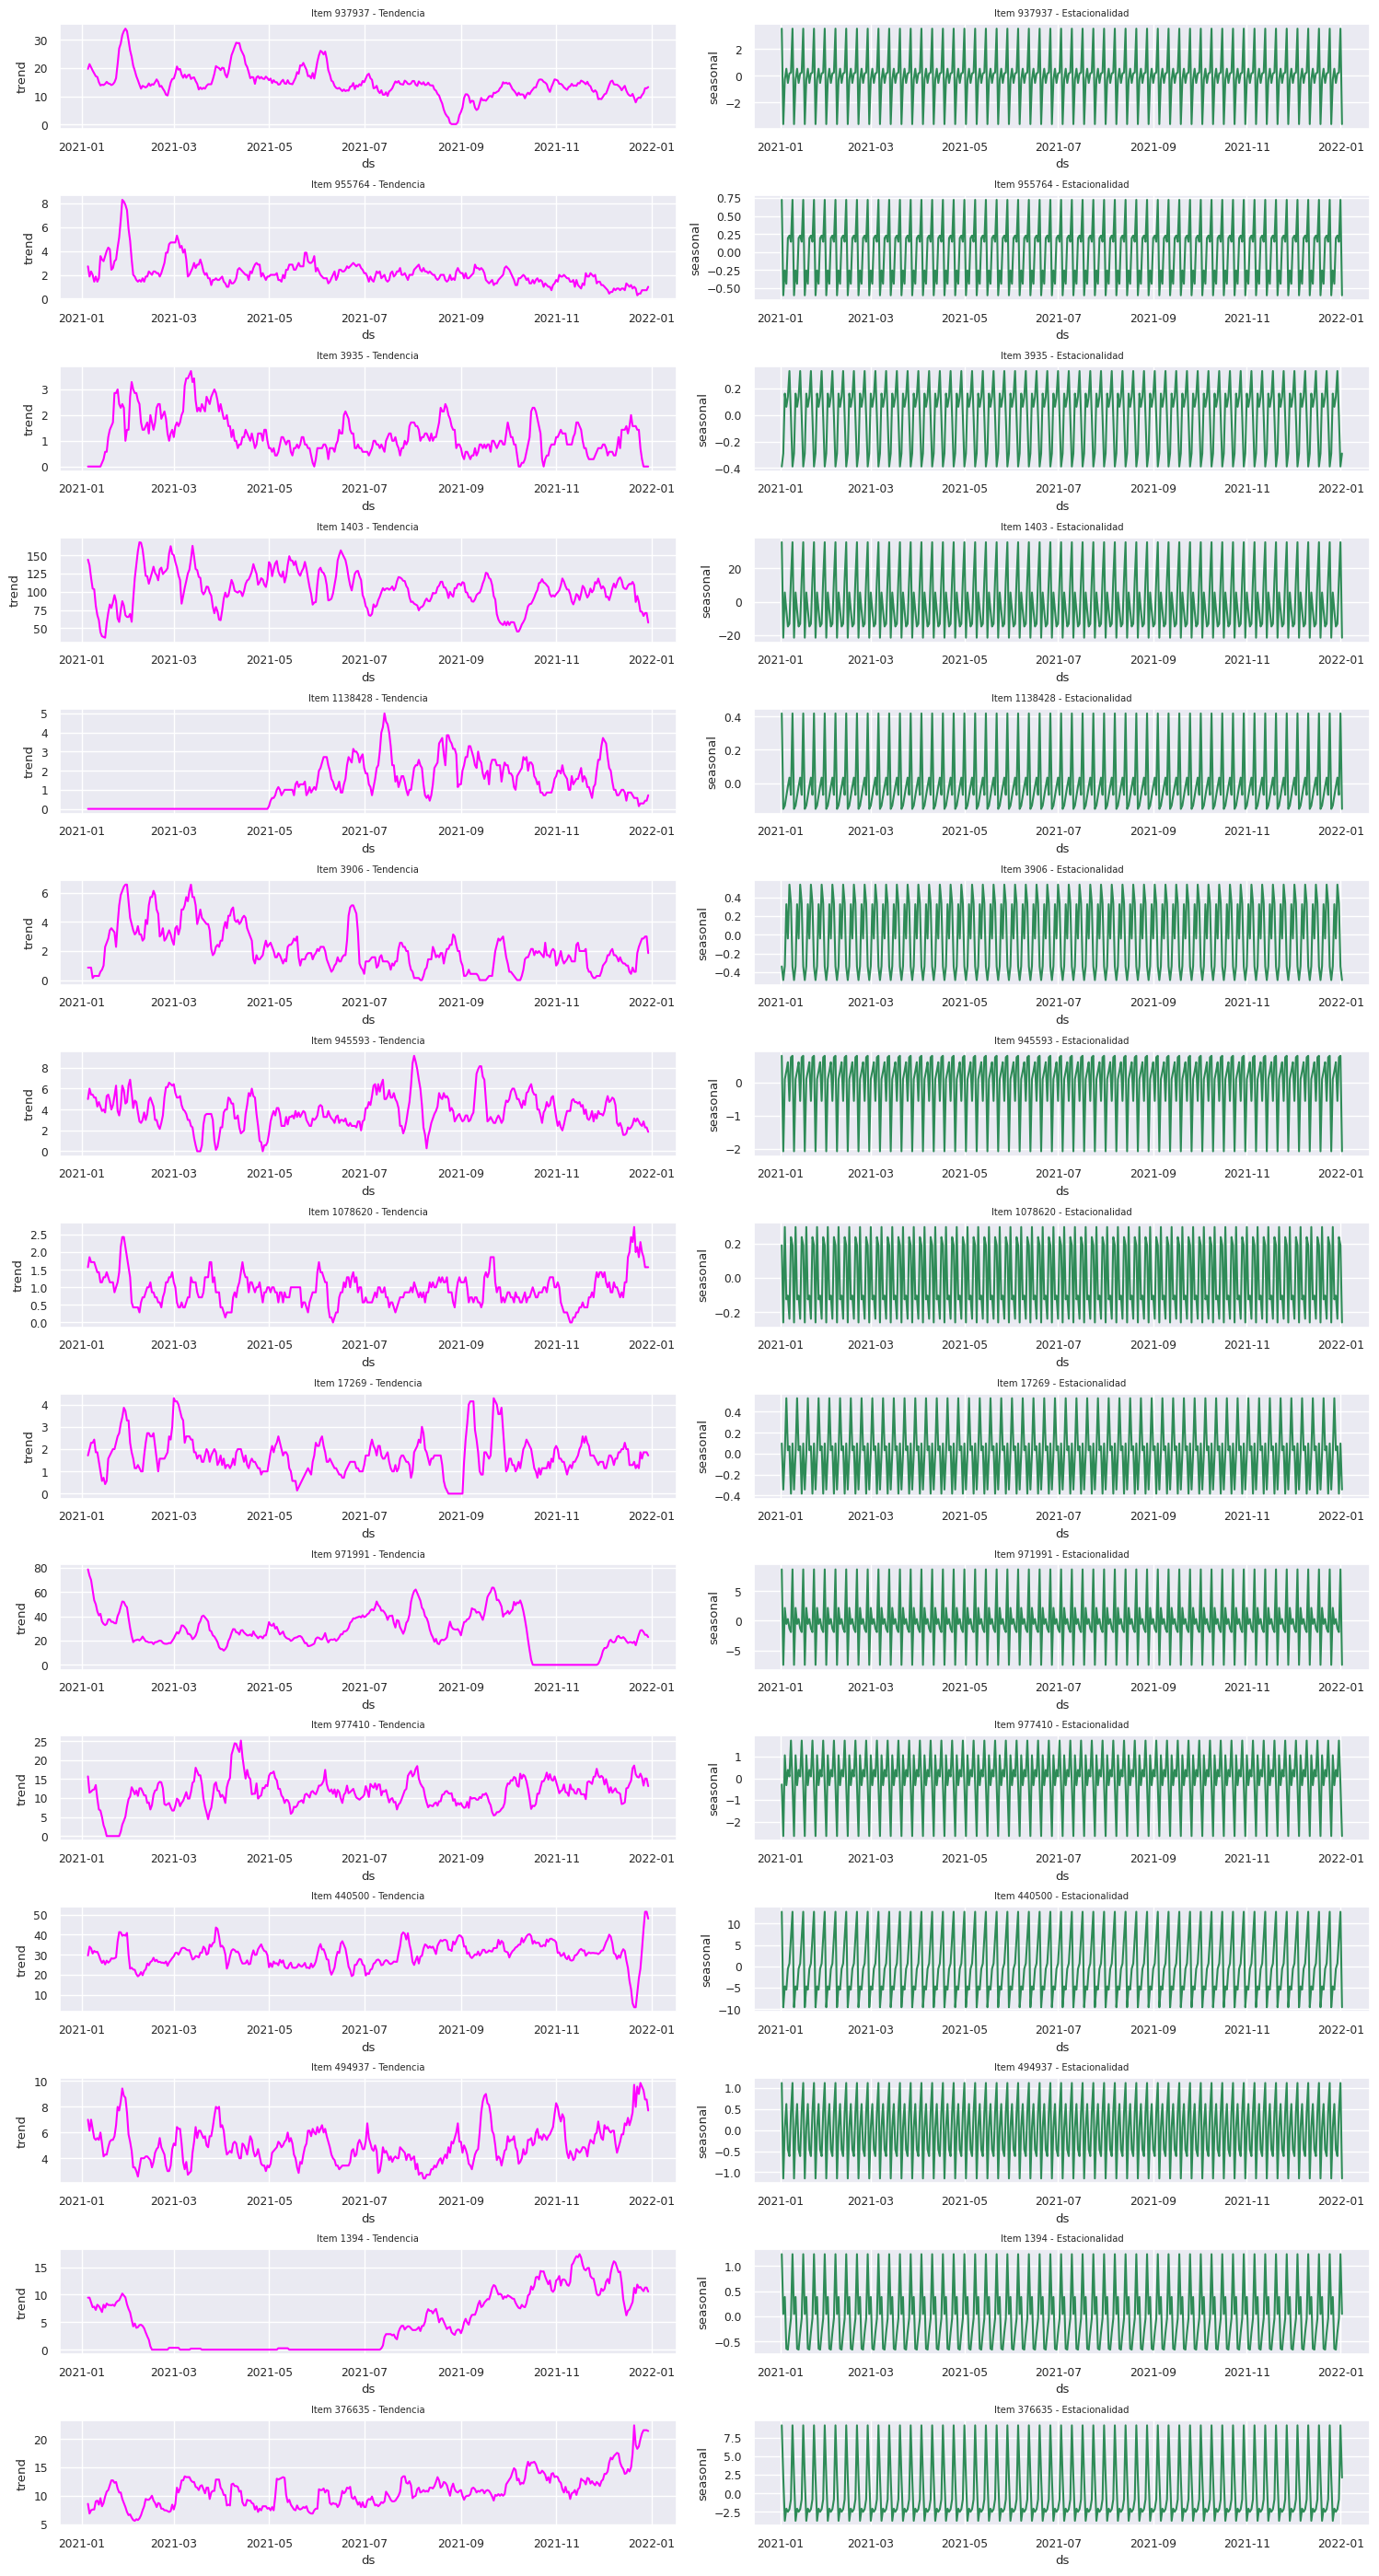

In [12]:
# Subplots para cada item
fig, axes = plt.subplots(len(unique_ids), 2, figsize=(15,28))
sns.set(font_scale=.6)

# Iteramos sobre los ids
for i, un_id in enumerate(unique_ids):
    
    dataset = df_train.loc[df_train.unique_id==un_id, ['ds', 'y']]
    dataset.index = dataset.ds
    dataset.drop(columns='ds', inplace=True)
    dataset.fillna(0, inplace=True)

    # Realizar la descomposición estacional para el dataset actual
    result = seasonal_decompose(dataset, model='additive')

    # Gráfico de la componente "Tendencia"
    sns.lineplot(data=dataset, x=dataset.index, y=result.trend,  color='magenta',ax=axes[i,0])
    axes[i,0].set_title(f'Item {un_id} - Tendencia')

    # Gráfico de la componente "Estacionalidad"
    sns.lineplot(data=dataset, x=dataset.index, y=result.seasonal, color='seagreen',ax=axes[i,1])
    axes[i,1].set_title(f'Item {un_id} - Estacionalidad')


plt.tight_layout()
plt.show()

En casi todas las gráficas podemos ver que hay un comportamiento estacional, solo en el utlimo item se observa una tendencia estacional. Ahora vamos a ajustar un modelo autoArima para cada uno de los items. El objetivo de auto_arima es encontrar el mejor modelo ARIMA para los datos de series temporales proporcionados, seleccionando automáticamente los valores óptimos para los parámetros p, d y q del modelo ARIMA.

### Ajuste de Modelo autoARIMA

AutoARIMA, de la librería pmdarima en Python, es una poderosa herramienta para el modelado automático de series de tiempo utilizando el algoritmo ARIMA (AutoRegressive Integrated Moving Average). Esta función simplifica en gran medida el proceso de selección de hiperparámetros y ajuste del modelo ARIMA, al automatizar la búsqueda exhaustiva de las combinaciones óptimas de parámetros.

El proceso de ajuste del modelo en AutoARIMA incluye la estimación automática de los órdenes de diferenciación (d) y de la parte autoregresiva (p) y la parte de promedio móvil (q) del modelo ARIMA. Además, permite la selección automática de los órdenes de diferenciación estacional (D) y los términos de autoregresión estacional (P) y promedio móvil estacional (Q) en el modelo SARIMA.

In [13]:
# Métricas que vamos a utlizar para evaluar los resultados
def prediction_mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def prediction_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

In [14]:
# Definimos el dataframe para guardar las predicciones y los errores
pred_mae = []
pred_rmse = []
df_predictions = pd.DataFrame()

# Iteramos sobre los items
for un_id in df_train.unique_id.unique():
    
    df_train_ = df_train.loc[df_train.unique_id==un_id, ['ds', 'y']]
    df_train_.index = df_train_.ds
    df_train_.drop(columns='ds', inplace=True)
    df_train_.fillna(0, inplace=True)
    
    df_val_ = df_val.loc[df_val.unique_id==un_id]
    df_val_.reset_index(drop=True,
                       inplace=True)

    # Ajuste del modelo y sus parámetros
    stepwise_model = auto_arima(df_train_, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    stepwise_model.fit(df_train_)
    
    # Realizamos las predicciones del los próximos 7 días
    stepwise_pred = stepwise_model.predict(n_periods=7).values
    stepwise_pred = pd.Series(stepwise_pred)
    predictions = pd.concat([df_val_, stepwise_pred],
                             axis=1)
    
    df_predictions = pd.concat([df_predictions, predictions],
                              ignore_index=True)
    
    # Evaluamos el error de predicción de cada item
    e_mae = prediction_mae(df_val_['y'], stepwise_pred)
    e_rmse = prediction_rmse(df_val_['y'], stepwise_pred)
    pred_rmse.append(e_rmse)
    pred_mae.append(e_mae)
    print('item_id:', un_id, 'rmse:', e_rmse, 'mae:', e_mae)
    
    # Guardamos cada uno de los modelos
    joblib.dump(stepwise_model, f'ARIMA/arima_{un_id}.pkl')
df_predictions = df_predictions.rename(columns={df_predictions.columns[-1]: 
                                                'yhat'})

pred_errors = {'item_id': df_train['unique_id'].unique(),
               'pred_mae': pred_mae,
               'pred_rmse': pred_rmse}
pred_errors = pd.DataFrame(pred_errors)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2721.749, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2569.800, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2673.723, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2541.526, Time=0.50 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2616.193, Time=0.42 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2521.056, Time=0.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2553.669, Time=0.43 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.10 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2514.094, Time=0.87 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2546.9

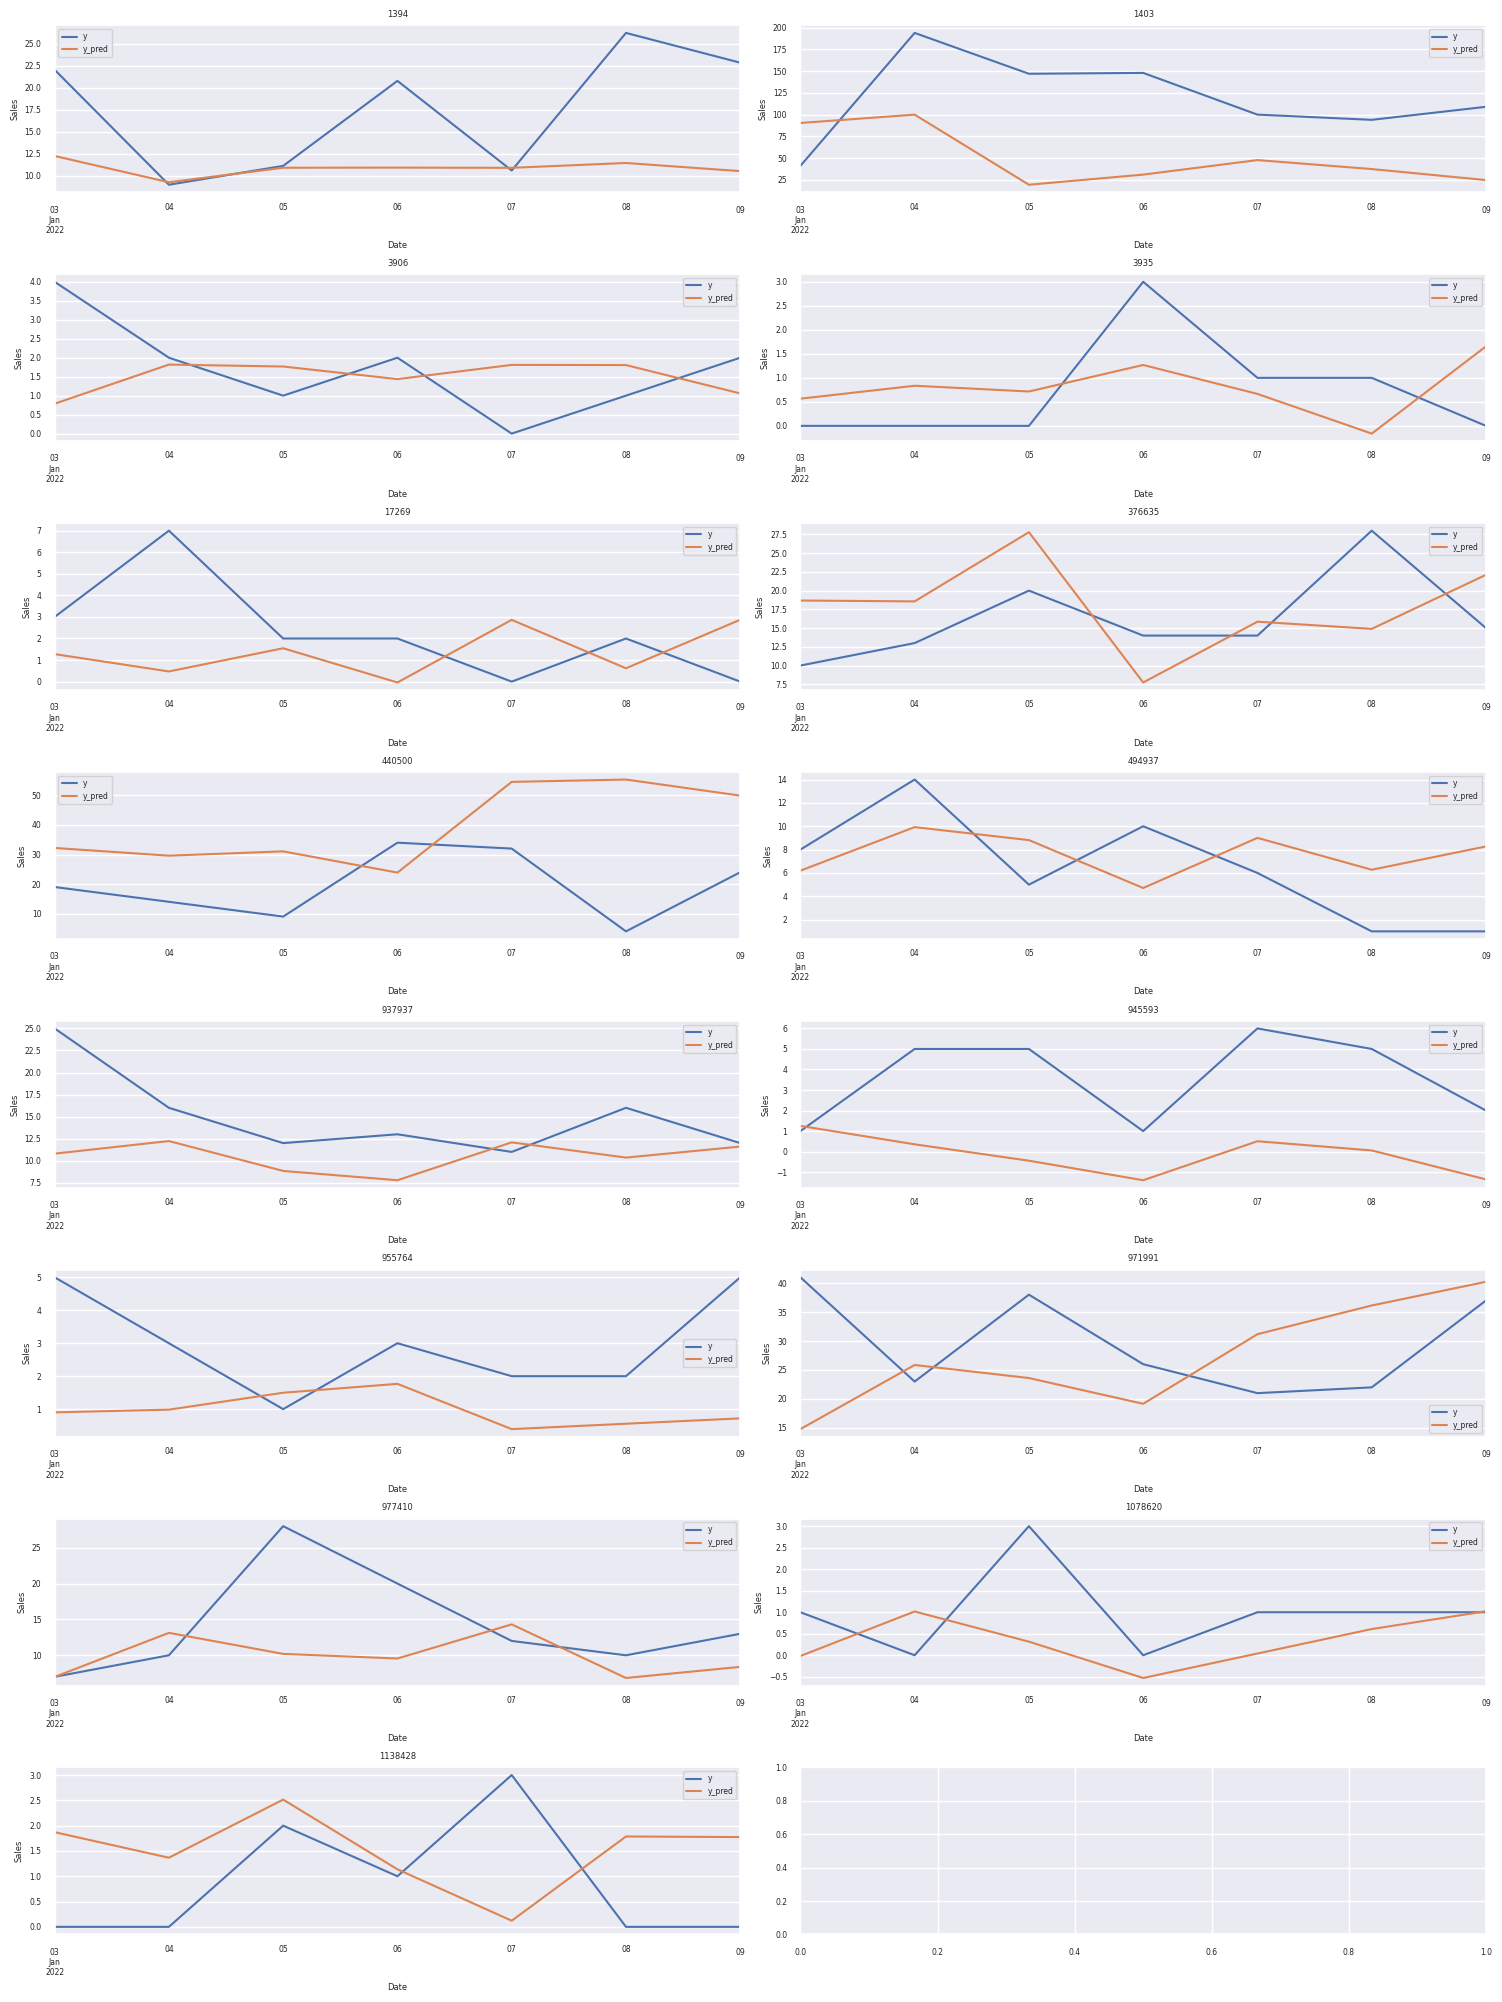

In [17]:
# Graficamos las predicciones vs el valor real para cada item
sns.set(font_scale=.5) 

fig, ax = plt.subplots(8,2, figsize=(15,20))
ax = ax.flatten()
for ax_ ,item_id in enumerate(sorted(df_predictions['unique_id'].unique())):
    p_ = df_predictions.loc[(df_predictions['unique_id'] == item_id)] 
    p_.plot(x='ds', y='y', ax=ax[ax_], label='y')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='y_pred')
    ax[ax_].set_title(item_id)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
fig.tight_layout()
plt.show()

In [19]:
pred_errors.sort_values(by='item_id')

,item_id,pred_mae,pred_rmse
13,1394,6.779397,8.954527
3,1403,83.052436,88.096541
5,3906,1.183207,1.515231
2,3935,1.000091,1.116889
8,17269,2.551299,3.123607
14,376635,7.195612,7.855588
11,440500,22.981034,26.259670
12,494937,4.361505,4.661383
0,937937,4.777995,6.391531
6,945593,3.788048,4.187962


Al analizar los errores de predicción de las ventas para diferentes ítems utilizando este modelo, se observa un **ajuste bastante bueno en los datos**. Sin embargo, es importante destacar que desde el punto de vista computacional, el modelo no es muy eficiente, ya que requiere de un tiempo considerable para realizar las predicciones de cada ítem. No obstante, existe la posibilidad de **paralelizar el proceso** para reducir el tiempo necesario. A pesar de estos resultados, continuaremos **explorando otros modelos** con el objetivo de obtener mejores resultados.

Referencias:
- https://forecastegy.com/posts/multiple-time-series-forecasting-with-arima-in-python/
- https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c